## Train Coarse-Grid Operator model and create an MGRIT solver

In [1]:
import os
import pdb
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, ExponentialLR
from torch.utils.data import Dataset, DataLoader, random_split

import scipy
from scipy import sparse as sp
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve

from pymgrit.core.mgrit import Mgrit
from pymgrit.heat.heat_1d import VectorHeat1D
from pymgrit.core.application import Application

from loss_functions import (NonGalerkinLoss1Rand, NonGalerkinLoss1Eig, 
                            NonGalerkinLoss2Eig, NonGalerkinLoss2EigConst, 
                            NonGalerkinLoss3Eig, NonGalerkinLoss3EigConst)
from constants import (
    device, input_size, output_size, hidden_size,
    batch_size, batch_num, epochs, learning_rate,
    nstencils, m, max_m,
    eps, eps_drop_period, eps_drop_period,
    learn_rate_drop_factor, learn_rate_drop_period,
    plot_landscape
)

# Numpy Settings
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Torch Settings
torch.set_default_dtype(torch.float32)
torch.manual_seed(0)

[Dagrazs-MacBook-Air.local:61158] shmem: mmap: an error occurred while determining whether or not /var/folders/fd/8p6y3p9d67l9ms3hzwcf97vm0000gn/T//ompi.Dagrazs-MacBook-Air.501/jf.0/1384382464/sm_segment.Dagrazs-MacBook-Air.501.52840000.0 could be created.


### Save model and plots in `models` directory

In [2]:
# Comment this cell, in case that you don't need to use this feature.

# Manually increase this variable each time you restart the notebook
model_num = 4

model_params = {
    "epochs" : epochs,
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "eps" : eps,
    "eps_drop_period" : eps_drop_period,
    "max_coarsening_factor" : max_m,
    "learning_rate_drop_factor" : learn_rate_drop_factor,
    "learning_rate_drop_period" : learn_rate_drop_period,
}

os.mkdir(f"{os.getcwd()}/models/psi-modelV{model_num}")

with open(f"models/psi-modelV{model_num}/params.json", mode="w", encoding="utf-8") as params_file:
    json.dump(model_params, params_file, indent=4)

## I. Set up Data

### Non Galerkin Dataset Class

In [3]:
class NonGalerkinDataset(Dataset):
    def __init__(self, array, transform=None, target_transform=None):
        self.stencil = array
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
      return len(self.stencil)

    def __getitem__(self, index):
        out = self.stencil[index]
        if self.transform:
            out = self.transform(out)
        return out

### One Stencil Setup

In [4]:
# dx = 1 / 16; dt = 1 / 4096
# beta = dt / dx ** 2
# stencil_dataset = torch.Tensor([beta, 1 - 2 * beta, beta]).repeat(nstencils, 1)
# stencil_dataset = torch.cat((stencil_dataset, m), 1).to(device)

### Multiple Stencil Setup

In [5]:
betas = torch.tensor([1/8, 1/12, 1/16, 1/24])

stencil_dataset = torch.torch.empty((0, betas.size()[0]), dtype=torch.float32).to(device)
for beta in betas:
    stencil_m = torch.Tensor([beta, 1 - 2 * beta, beta]).repeat(nstencils, 1).to(device)
    stencil_m = torch.cat((stencil_m, m), 1)
    stencil_dataset = torch.cat((stencil_dataset, stencil_m), 0)

### Create Stencil Dataset

In [6]:
dataset = NonGalerkinDataset(stencil_dataset)
Ndata = len(dataset); 
Ntest = 0; Ntrain = Ndata - Ntest
dataset_train, dataset_test = random_split(dataset, [Ntrain, Ntest])
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Print test dataset
print(f"Train set size {Ntrain}, Test set size {Ntest}, batch size {batch_size}")
stencil_dataset

Train set size 16, Test set size 0, batch size 4


tensor([[0.1250, 0.7500, 0.1250, 1.0000],
        [0.1250, 0.7500, 0.1250, 2.0000],
        [0.1250, 0.7500, 0.1250, 3.0000],
        [0.1250, 0.7500, 0.1250, 4.0000],
        [0.0833, 0.8333, 0.0833, 1.0000],
        [0.0833, 0.8333, 0.0833, 2.0000],
        [0.0833, 0.8333, 0.0833, 3.0000],
        [0.0833, 0.8333, 0.0833, 4.0000],
        [0.0625, 0.8750, 0.0625, 1.0000],
        [0.0625, 0.8750, 0.0625, 2.0000],
        [0.0625, 0.8750, 0.0625, 3.0000],
        [0.0625, 0.8750, 0.0625, 4.0000],
        [0.0417, 0.9167, 0.0417, 1.0000],
        [0.0417, 0.9167, 0.0417, 2.0000],
        [0.0417, 0.9167, 0.0417, 3.0000],
        [0.0417, 0.9167, 0.0417, 4.0000]], device='mps:0')

## II. Set up Neural Network

In [7]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, array):
        y = self.linear_relu_stack(array)
        return y

net = Net().to(device)

## III. Training Loop

### Set up Training Step

In [8]:
def train_loop(dataloader:DataLoader, model:nn.Module, loss_fn:nn.Module, optimizer:torch.optim, eps:float=1e-2):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    losses = []
    
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        input_batch = X
        output_batch = model(X)

        # Modify inputs to loss function depending on loss function used
        loss = loss_fn(input_batch, output_batch)
        
        # Back propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

        if batch % min(1, num_batches - 1) == 0:
            loss, current = loss.item(), batch * batch_size + len(input_batch)
            print(f"Train Loss: {loss:>7e}  [{current:>5d}/{size:>5d}]")
    return losses

### Select Loss Function
- $\mathcal{L1}$: NonGalerkinLoss1Rand | NonGalerkinLoss1Eig  

- $\mathcal{L2}$: NonGalerkinLoss2Eig | NonGalerkinLoss2EigConst

- $\mathcal{L3}$: NonGalerkinLoss3Eig | NonGalerkinLoss3EigCons

In [9]:
loss_fn = NonGalerkinLoss1Rand()

### Select Optimizer and Scheduler

In [10]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, learn_rate_drop_factor)

In [11]:
loss_vis = np.zeros((epochs, batch_num))

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    loss = train_loop(train_loader, net, loss_fn, optimizer)

    # Print change of loss throughout training
    loss_vis[epoch] = np.array(sum(loss))
    
    # Modify eps throughout training for Loss 1
    if ((epoch + 1) % eps_drop_period == 0):
        eps = eps / 2

    # Modify learning rate throughout training
    if ((epoch + 1) % learn_rate_drop_period == 0):
        scheduler.step()
        print("Update learning rate")


Epoch 1
-------------------------------
Train Loss: 1.044067e+03  [    4/   16]
Train Loss: 4.263561e+01  [    8/   16]
Train Loss: 5.083861e+01  [   12/   16]
Train Loss: 8.328677e+01  [   16/   16]
Epoch 2
-------------------------------
Train Loss: 1.077091e+01  [    4/   16]
Train Loss: 5.071209e+01  [    8/   16]
Train Loss: 3.848468e+01  [   12/   16]
Train Loss: 2.882785e+01  [   16/   16]
Epoch 3
-------------------------------
Train Loss: 2.220641e+01  [    4/   16]
Train Loss: 1.233481e+01  [    8/   16]
Train Loss: 2.176980e+01  [   12/   16]
Train Loss: 1.324325e+01  [   16/   16]
Epoch 4
-------------------------------
Train Loss: 9.304908e+00  [    4/   16]
Train Loss: 4.707254e+00  [    8/   16]
Train Loss: 1.836084e+01  [   12/   16]
Train Loss: 7.902563e+00  [   16/   16]
Epoch 5
-------------------------------
Train Loss: 1.779218e+01  [    4/   16]
Train Loss: 9.761078e+00  [    8/   16]
Train Loss: 4.068226e+00  [   12/   16]
Train Loss: 1.282046e+00  [   16/   16]


### Loss Graph

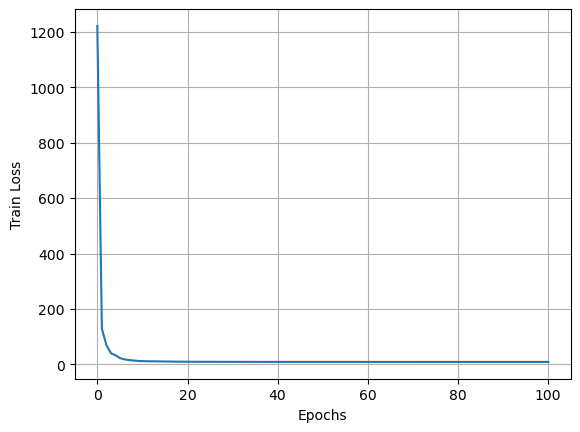

In [12]:
num_of_coord = (nstencils // batch_size) * epochs
loss_vis = np.reshape(loss_vis, (1, num_of_coord))
x = np.linspace(0, num_of_coord, num_of_coord)
plt.plot(x, loss_vis[0])
plt.xlabel('Epochs'); plt.ylabel("Train Loss")
plt.grid()
plt.savefig(f'models/psi-modelV{model_num}/loss.png')
plt.show()

## IV. Save & Load the Trained NN

In [13]:
torch.save(net.state_dict(), f"models/psi-modelV{model_num}/model")

In [14]:
model = Net().to(device)
model.load_state_dict(torch.load(f"models/psi-modelV{model_num}/model", weights_only=True))
model.eval()

Net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)

## V. Test the model with Stencils

In [16]:
trained_stencils = Ndata // nstencils
trained_phis = pd.DataFrame(columns=['# Stencils','Beta Value', 'PHI', 'PSI', 'DSC'])
trained_phis.set_index('# Stencils', inplace=True)
nontrained_phis = pd.DataFrame(columns=['# Stencils','Beta Value', 'PHI', 'PSI', 'DSC'])
nontrained_phis.set_index('# Stencils', inplace=True)

print("This is the phi we trained on")
dt = 1 / 4096; dx = 1 / 16
beta = dt / dx ** 2
m = 2

phi_m = torch.tensor([beta, 1 - 2 * beta, beta, m]).to(device).reshape((1,4))
psi = model(phi_m).reshape((1,3))
disc = torch.tensor([m*beta, 1 - 2 * m*beta, m*beta]).to(device).reshape((1,3))
loss_psi = loss_fn(phi_m, psi, eps)
loss_disc = loss_fn(phi_m, disc, eps)
print(f"phi = {phi_m}")
print(f"psi = {psi.detach()}")
print(f"output of loss function on psi: {loss_psi}")
print(f"dsc = {disc}")
print(f"output of loss function on disc: {loss_disc}")

for i in range(trained_stencils):
    phi_m = torch.Tensor([betas[i], 1 - 2 * betas[i], betas[i], m]).to(device)
    psi = model(phi_m)
    disc = torch.Tensor([m * betas[i], 1 - 2 * m * betas[i], m * betas[i]]).to(device)
    trained_phis.loc[i+1] = [betas[i].item(), 
                             phi_m.detach().cpu().numpy(), 
                             psi.detach().cpu().numpy(), 
                             disc.detach().cpu().numpy()]

trained_phis

This is the phi we trained on
phi = tensor([[0.0625, 0.8750, 0.0625, 2.0000]], device='mps:0')
psi = tensor([[0.1826, 0.6943, 0.1393]], device='mps:0')
output of loss function on psi: 2760335.5
dsc = tensor([[0.1250, 0.7500, 0.1250]], device='mps:0')
output of loss function on disc: 0.02521401271224022


,Beta Value,PHI,PSI,DSC
# Stencils,,,,
1,0.125000,"[0.125, 0.75, 0.125, 2.0]","[0.18138719, 0.68999, 0.13799983]","[0.25, 0.5, 0.25]"
2,0.083333,"[0.083333336, 0.8333333, 0.083333336, 2.0]","[0.1822277, 0.6928219, 0.13894556]","[0.16666667, 0.6666666, 0.16666667]"
3,0.062500,"[0.0625, 0.875, 0.0625, 2.0]","[0.18259221, 0.69432944, 0.13930315]","[0.125, 0.75, 0.125]"
4,0.041667,"[0.041666668, 0.9166667, 0.041666668, 2.0]","[0.18304011, 0.6957488, 0.13974051]","[0.083333336, 0.8333333, 0.083333336]"


In [17]:
print("This is not the phi we trained on")
dt = 1 / 4096; dx = 1 / 16
beta = dt / dx ** 2
m = 2

for j in range(trained_stencils):
    phi_m = torch.Tensor([betas[j], 1 - 2 * betas[j], betas[j], m]).to(device)
    psi = model(phi_m)
    disc = torch.Tensor([m * betas[j], 1 - 2 * m * betas[j], m * betas[j]]).to(device)
    nontrained_phis.loc[j+1] = [betas[j].item(), 
                                phi_m.detach().cpu().numpy(), 
                                psi.detach().cpu().numpy(), 
                                disc.detach().cpu().numpy()]
    
phi_m = torch.tensor([beta, 1 - 2 * beta, beta, m]).to(device).reshape((1,4))
psi = model(phi_m).reshape((1,3))
disc = torch.tensor([m*beta, 1 - 2 * m*beta, m*beta]).to(device).reshape((1,3))
loss_psi = loss_fn(phi_m, psi, eps)
loss_disc = loss_fn(phi_m, disc, eps)
print(f"phi = {phi_m}")
print(f"psi = {psi.detach()}")
print(f"output of loss function on psi: {loss_psi}")
print(f"dsc = {disc}")
print(f"output of loss function on disc: {loss_disc}")

nontrained_phis

This is not the phi we trained on
phi = tensor([[0.0625, 0.8750, 0.0625, 2.0000]], device='mps:0')
psi = tensor([[0.1826, 0.6943, 0.1393]], device='mps:0')
output of loss function on psi: 2760335.5
dsc = tensor([[0.1250, 0.7500, 0.1250]], device='mps:0')
output of loss function on disc: 0.02521401271224022


,Beta Value,PHI,PSI,DSC
# Stencils,,,,
1,0.125000,"[0.125, 0.75, 0.125, 2.0]","[0.18138719, 0.68999, 0.13799983]","[0.25, 0.5, 0.25]"
2,0.083333,"[0.083333336, 0.8333333, 0.083333336, 2.0]","[0.1822277, 0.6928219, 0.13894556]","[0.16666667, 0.6666666, 0.16666667]"
3,0.062500,"[0.0625, 0.875, 0.0625, 2.0]","[0.18259221, 0.69432944, 0.13930315]","[0.125, 0.75, 0.125]"
4,0.041667,"[0.041666668, 0.9166667, 0.041666668, 2.0]","[0.18304011, 0.6957488, 0.13974051]","[0.083333336, 0.8333333, 0.083333336]"


### Get Optimal Stencil

In [18]:
dt = 1 / 4096
dx = 1/ 16
beta = dt / dx ** 2
m = 4
phi_m = torch.tensor([beta, 1 - 2 * beta, beta, m]).to(device)
print(phi_m)

x0 = torch.tensor([x[0], x[1], x[0]]).reshape((1,3))
x0[0,-1]

print(x0[0,1:])

def loss(x):
    loss = loss_fn(phi_m.reshape((1,4)), torch.tensor([x[0], x[1], x[0]]).reshape((1,3)), eps)
    return loss.item()

opt = scipy.optimize.minimize(loss, [1,1], method='Nelder-Mead')
optimal_stencil = torch.tensor([opt.x[0], opt.x[1], opt.x[0]])
print(optimal_stencil)

tensor([0.0625, 0.8750, 0.0625, 4.0000], device='mps:0')
tensor([1.0101, 0.0000], dtype=torch.float64)
tensor([0.1818, 0.6364, 0.1818], dtype=torch.float64)


### Loss Landscape Heatmap

In [19]:
# Plot Loss Landscape
if plot_landscape:
    n = 200
    dt = 1/4096
    dx = 1/16
    beta = dt / dx ** 2
    m = 4
    phi_m = torch.tensor([beta, 1 - 2 *  beta, beta, m]).to(device).reshape([1, 4])
    psis = torch.from_numpy(np.fromfunction(
        lambda i, j: np.array([i / n, j / n, i / n]),
        [n, n]
    )).to(device)

    losses = torch.tensor(size = [n, n])
    for i in range(n):
        if i % 10 == 0:
            print(i)
        for j in range(n):
            losses[i, j] = loss_fn(phi_m, psis[:, i, j].reshape([1, 3]), eps)

                
    plt.imshow(losses, aspect = 1, origin = 'lower', norm=LogNorm(vmin=0.001, vmax=1))
    plt.colorbar()
    plt.scatter([100], [50], c = 'red', marker = 'x')
    plt.xticks(range(0, n + 1, n / 5), [0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.yticks(range(0, n + 1, n / 5), [0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Loss 1 with rand and const, eps=1e-2, for matrix [a, b, a]')
    plt.xlabel('b')
    plt.ylabel('a')
    plt.show()

## VI. PyMGRIT Integration

### Heat1DExp and Heat1DNN Classes

In [20]:
"""
Vector and application class for the 1D heat equation

This extends the Python code
"""
##########

class Heat1DExp(Application):
    """
    Application class for the heat equation in 1D space,
        u_t - a*u_xx = b(x,t),  a > 0, x in [x_start,x_end], t in [0,T],
    with periodic boundary conditions in space and explicit forward Euler discretization.
    """

    def __init__(self, x_start, x_end, nx, a, init_cond=lambda x: x * 0, rhs=lambda x, t: x * 0, *args, **kwargs):
        """
        Constructor.

        :param x_start: left interval bound of spatial domain
        :param x_end: right interval bound of spatial domain
        :param nx: number of spatial degrees of freedom
        :param a: thermal conductivity
        :param init_cond: initial condition
        :param rhs: right-hand side
        """

        super().__init__(*args, **kwargs)
        # Spatial domain with homogeneous Dirichlet boundary conditions
        self.x_start = x_start
        self.x_end = x_end
        self.x = np.linspace(self.x_start, self.x_end, nx)
        self.x = self.x[0:-1]
        self.nx = nx - 1
        self.dx = self.x[1] - self.x[0]

        # Thermal conductivity
        self.a = a

        # Set (spatial) identity matrix and spatial discretization matrix
        self.identity = identity(self.nx, dtype='float', format='csr')
        self.space_disc = self.compute_matrix()

        # Set right-hand side routine
        self.rhs = rhs

        # Set the data structure for any user-defined time point
        self.vector_template = VectorHeat1D(self.nx)

        # Set initial condition
        self.init_cond = init_cond
        self.vector_t_start = VectorHeat1D(self.nx)
        self.vector_t_start.set_values(self.init_cond(self.x))

    def compute_matrix(self):
        """
        Define spatial discretization matrix for 1D heat equation (forward Euler)

        Second-order central finite differences with matrix stencil (periodic BCs)
           (a / dx^2) * [-1  2  -1]
        """

        fac = self.a / self.dx ** 2

        diagonal = np.ones(self.nx) * 2 * fac
        lower = np.ones(self.nx - 1) * -fac
        upper = np.ones(self.nx - 1) * -fac

        # diagonal = np.ones(self.nx) * 2 * 0.6231
        # lower = np.ones(self.nx - 1) * -0.1721
        # upper = np.ones(self.nx - 1) * -0.1715

        matrix = sp.diags(
            diagonals=[diagonal, lower, upper, lower, upper],
            offsets=[0, -1, 1, self.nx-1, -self.nx+1], shape=(self.nx, self.nx),
            format='csr')

        return matrix

    def step(self, u_start: VectorHeat1D, t_start: float, t_stop: float) -> VectorHeat1D:
        """
        Time integration routine for 1D heat equation example problem:
            Forward Euler

        One-step method
           u_i = (I - dt*L) * u_{i-1} + dt*b_{i-1},
        where L = self.space_disc is the spatial discretization operator

        :param u_start: approximate solution for the input time t_start
        :param t_start: time associated with the input approximate solution u_start
        :param t_stop: time to evolve the input approximate solution to
        :return: approximate solution at input time t_stop
        """
        dt = (t_stop - t_start)
        tmp = u_start.get_values()
        # This is the implicit step for reference
        # tmp = spsolve(self.identity + dt * self.space_disc,
        #               tmp + dt * self.rhs(self.x, t_stop))
        tmp = (self.identity - dt * self.space_disc) * tmp + dt * self.rhs(self.x, t_start)
        ret = VectorHeat1D(len(tmp))
        ret.set_values(tmp)
        return ret


##########

class Heat1DNN(Application):
    """
    Application class for the heat equation in 1D space,
        u_t - a*u_xx = b(x,t),  a > 0, x in [x_start,x_end], t in [0,T],
    with periodic boundary conditions in space and offline-trained neural network model.
    """

    def __init__(self, model, x_start, x_end, nx, a, m, init_cond=lambda x: x * 0, rhs=lambda x, t: x * 0, *args, **kwargs):
        """
        Constructor.

        :param x_start: left interval bound of spatial domain
        :param x_end: right interval bound of spatial domain
        :param nx: number of spatial degrees of freedom
        :param a: thermal conductivity
        :param init_cond: initial condition
        :param rhs: right-hand side
        """

        super().__init__(*args, **kwargs)
        # Spatial domain with homogeneous Dirichlet boundary conditions
        self.model = model
        self.x_start = x_start
        self.x_end = x_end
        self.x = np.linspace(self.x_start, self.x_end, nx)
        self.x = self.x[0:-1]
        self.nx = nx - 1
        self.dx = self.x[1] - self.x[0]
        self.m = m

        # Thermal conductivity
        self.a = a

        # Set right-hand side routine
        self.rhs = rhs

        # Set the data structure for any user-defined time point
        self.vector_template = VectorHeat1D(self.nx)

        # Set initial condition
        self.init_cond = init_cond
        self.vector_t_start = VectorHeat1D(self.nx)
        self.vector_t_start.set_values(self.init_cond(self.x))

    def step(self, u_start: VectorHeat1D, t_start: float, t_stop: float) -> VectorHeat1D:
        """
        Time integration routine for 1D heat equation example problem:
            Neural Network Model

        One-step method
           u_i = psi * u_{i-1} + dt*b_{i-1},
        where psi is the NN model

        :param u_start: approximate solution for the input time t_start
        :param t_start: time associated with the input approximate solution u_start
        :param t_stop: time to evolve the input approximate solution to
        :return: approximate solution at input time t_stop
        """

        # compute dt and beta for the finest mesh
        dt = (t_stop - t_start) / self.m
        beta = dt * self.a / self.dx ** 2

        # use NN to get psi
        phi_m = torch.Tensor([beta, 1 - 2 * beta, beta, self.m]).to(device)
        psi_model = self.model(phi_m).to(device)

        # this assumes a 3-point stencil (for now)
        diagonal = np.ones(self.nx)  * psi_model[1].item()
        lower = np.ones(self.nx - 1) * psi_model[0].item()
        upper = np.ones(self.nx - 1) * psi_model[2].item()

        psi = sp.diags(
            diagonals=[diagonal, lower, upper, lower, upper],
            offsets=[0, -1, 1, self.nx-1, -self.nx+1], shape=(self.nx, self.nx),
            format='csr')
        
        tmp = u_start.get_values()
        tmp = psi * tmp + dt * self.rhs(self.x, t_start)
        ret = VectorHeat1D(len(tmp))
        ret.set_values(tmp)
        return ret
    

### Create PyMGRIT solver

INFO - 21-08-24 00:15:32 - Start setup
INFO - 21-08-24 00:15:32 - Setup took 0.12755608558654785 s
INFO - 21-08-24 00:15:32 - Start solve
INFO - 21-08-24 00:15:36 - iter 1  | conv: 2.1204169197850664      | conv factor: -                     | runtime: 3.2040350437164307 s   
INFO - 21-08-24 00:15:39 - iter 2  | conv: 0.5859857256426864      | conv factor: 0.2763540132956891    | runtime: 3.0587408542633057 s   
INFO - 21-08-24 00:15:42 - iter 3  | conv: 0.3309415263193445      | conv factor: 0.5647603889265062    | runtime: 3.034346103668213 s    
INFO - 21-08-24 00:15:45 - iter 4  | conv: 0.19825140817779868     | conv factor: 0.5990526797368261    | runtime: 2.996835947036743 s    
INFO - 21-08-24 00:15:48 - iter 5  | conv: 0.1206066261662909      | conv factor: 0.6083519268530326    | runtime: 3.088974714279175 s    
INFO - 21-08-24 00:15:51 - iter 6  | conv: 0.07412534716202547     | conv factor: 0.6146042677607313    | runtime: 3.036240339279175 s    
INFO - 21-08-24 00:15:54 - i

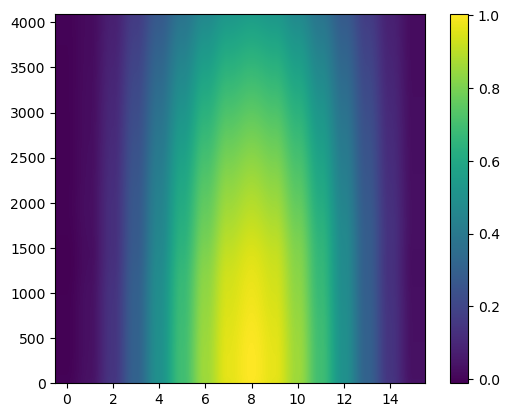

In [21]:
def main(plotting=False):
    def rhs(x, t):
        """
        Right-hand side of 1D heat equation example problem at a given space-time point (x,t),
        :param x: spatial grid point
        :param t: time point
        :return: right-hand side of 1D heat equation example problem at point (x,t)
        """

        return -(np.sin(t))*(np.sin(np.pi*x)**2) - 2*(np.pi**2)*(np.cos(t))*((np.cos(np.pi*x)**2) - (np.sin(np.pi*x)**2))

    def init_cond(x):
        """
        Initial condition of 1D heat equation example,
        :param x: spatial grid point
        :return: initial condition of 1D heat equation example problem
        """
        return np.sin(np.pi * x) ** 2

    # Domain: space = [0,1], time = [0,1]
    # nx = 17    =>  dx = 1/16
    # nt = 4097  =>  dt = 1/4096
    #            =>  beta = dt/dx^2 = 256/4096 = 1/16  (allows coarsening by up to 8)
    # Coarsen by a factor of 4 in time (from 4097 to 1025 points)
    # 
    heat0 = Heat1DExp(x_start=0, x_end=1, nx=17, a=1, init_cond=init_cond, rhs=rhs, t_start=0, t_stop=1, nt=4097)
    # heat1 = Heat1DNN(model, x_start=0, x_end=1, nx=17, a=1, m=2, init_cond=init_cond, rhs=rhs, t_start=0, t_stop=1, nt=1281)
    heat2 = Heat1DNN(model, x_start=0, x_end=1, nx=17, a=1, m=4, init_cond=init_cond, rhs=rhs, t_start=0, t_stop=1, nt=1025)

    # Setup two-level MGRIT solver and solve the problem
    problem = [heat0, heat2]
    mgrit = Mgrit(problem=problem, cf_iter=1, cycle_type='V', nested_iteration=False, max_iter=10,
                  logging_lvl=20, random_init_guess=True)
    info = mgrit.solve()

    if plotting:
        nt = len(mgrit.u[0])
        nx = mgrit.u[0][0].size
        values = [mgrit.u[0][i].get_values() for i in range(nt)]
        sol = np.vstack([np.array(val) for val in values])
        plt.imshow(sol, aspect=nx/nt, origin='lower')
        plt.savefig(f'models/psi-modelV{model_num}/heatmap.png')
        plt.colorbar()


if __name__ == '__main__':
    main(plotting=True)
    plt.show()


In [ ]:
info